In [93]:
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [94]:
# Klassennamen:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [95]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
# Trainingsdatensatz:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [96]:
# Validierungsdatensatz:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [97]:
# Alle Flugzeug- und Vögelbilder raussuchen:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [98]:
# baseline convolutional network architecture: 
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [99]:
# baseline convolutional network architecture: 

# 5 x 5 Kernel:
class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [100]:
# Model definieren:
model = Net()
model5 = Net5()

# Anzahl an Parameter des Models auasgeben:
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

numel_list5 = [p.numel() for p in model5.parameters()]
print(sum(numel_list5), numel_list5)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]
20906 [1200, 16, 3200, 8, 16384, 32, 64, 2]


FRAGE:
Wie verändert sich die Anzahl der freien Parameter im Modell?

Die Anzahl der freien Parameter im Modell wird höher, sobald ein 5 x 5 Kernel anstatt eines 3 x 3 Kernels verwendet wird.

In [101]:
import datetime  
# Trainingsloop für Validierungs- und Trainingsdaten:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    trainingsloss = np.zeros(n_epochs)
    validierungsloss = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1): 
        loss_train = 0.0
        for imgs, labels in train_loader: 
            outputs = model(imgs)  
            losses_train = loss_fn(outputs, labels) 
            optimizer.zero_grad()  
            losses_train.backward()  
            optimizer.step()  
            loss_train += losses_train.item()  
    
        loss_val = 0.0 
        for imgs, labels in val_loader: 
            outputs = model(imgs)  
            losses_val = loss_fn(outputs, labels) 
            optimizer.zero_grad() 
            optimizer.step()  
            loss_val += losses_val.item()  

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader):.4f},"
                  f" Validation loss {loss_val / len(val_loader):.4f}")

        validierungsloss[epoch-1] = loss_val / len(val_loader) # Valideriungsverlust
        trainingsloss[epoch-1] = loss_train / len(train_loader) # Trainingsverlust
        
    return trainingsloss, validierungsloss

In [102]:
# Training
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                           shuffle=True)


model = Net()  
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  

trainingsloss, validierungsloss = training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)

Epoch 1, Training loss 0.5606, Validation loss 0.4813
Epoch 10, Training loss 0.3329, Validation loss 0.3392
Epoch 20, Training loss 0.2966, Validation loss 0.3108
Epoch 30, Training loss 0.2698, Validation loss 0.2944
Epoch 40, Training loss 0.2457, Validation loss 0.2798
Epoch 50, Training loss 0.2289, Validation loss 0.2753
Epoch 60, Training loss 0.2115, Validation loss 0.2675
Epoch 70, Training loss 0.1956, Validation loss 0.2616
Epoch 80, Training loss 0.1815, Validation loss 0.2532
Epoch 90, Training loss 0.1656, Validation loss 0.2613
Epoch 100, Training loss 0.1539, Validation loss 0.2701


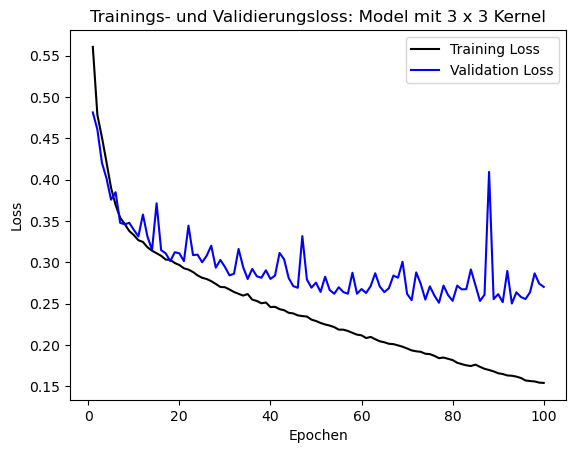

In [103]:
# Trainings- und Validierungsloss

epochs_train = range(1, len(trainingsloss) + 1) 
epochs_val = range(1, len(validierungsloss) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss, 'b', label='Validation Loss')
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.title('Trainings- und Validierungsloss: Model mit 3 x 3 Kernel')
plt.legend(loc="best")
plt.show()

In [104]:
# Trainingsloop für Validierungs- und Trainingsdaten: 5 x 5 Kernel
def training_loop5(n_epochs, optimizer5, model5, loss_fn5, train_loader5, val_loader5):
    trainingsloss5 = np.zeros(n_epochs)
    validierungsloss5 = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1): 
        loss_train5 = 0.0
        for imgs, labels5 in train_loader5: 
            outputs5 = model(imgs)  
            losses_train5 = loss_fn(outputs5, labels5) 
            optimizer5.zero_grad()  
            losses_train5.backward()  
            optimizer5.step()  
            loss_train5 += losses_train5.item()  
    
        loss_val5 = 0.0 
        for imgs, labels5 in val_loader5: 
            outputs5 = model(imgs)  
            losses_val5 = loss_fn(outputs5, labels5) 
            optimizer5.zero_grad()   
            optimizer5.step()  
            loss_val5 += losses_val5.item()  

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train5 / len(train_loader5):.4f},"
                  f" Validation loss {loss_val5 / len(val_loader5):.4f}")
        
        validierungsloss5[epoch-1] = loss_val5 / len(val_loader5) # Valideriungsverlust
        trainingsloss5[epoch-1] = loss_train5 / len(train_loader5) # Trainingsverlust
        

    return trainingsloss5, validierungsloss5

In [105]:
# Training (5 x 5 Kernel)

train_loader5 = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)  
val_loader5 = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=True)
 
model5 = Net5()
optimizer5 = optim.SGD(model5.parameters(), lr=1e-2)  
loss_fn5 = nn.CrossEntropyLoss()  

trainingsloss5, validierungsloss5 = training_loop5(  
    n_epochs=100,
    optimizer5=optimizer5,
    model5=model5,
    loss_fn5=loss_fn5,
    train_loader5=train_loader5,
    val_loader5=val_loader5
)

Epoch 1, Training loss 0.1615, Validation loss 0.2619
Epoch 10, Training loss 0.1601, Validation loss 0.2679
Epoch 20, Training loss 0.1607, Validation loss 0.2741
Epoch 30, Training loss 0.1616, Validation loss 0.2633
Epoch 40, Training loss 0.1604, Validation loss 0.2652
Epoch 50, Training loss 0.1602, Validation loss 0.2729
Epoch 60, Training loss 0.1603, Validation loss 0.2702
Epoch 70, Training loss 0.1607, Validation loss 0.2601
Epoch 80, Training loss 0.1606, Validation loss 0.2660
Epoch 90, Training loss 0.1611, Validation loss 0.2625
Epoch 100, Training loss 0.1606, Validation loss 0.2629


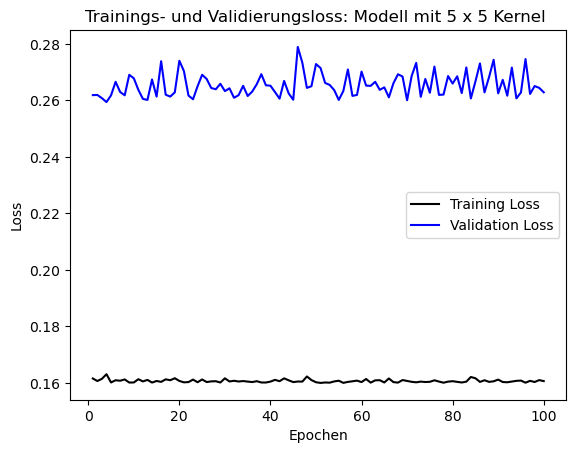

In [106]:
# Trainings- und Validierungsloss: Kernel 5 x 5

epochs_train = range(1, len(trainingsloss5) + 1) 
epochs_val = range(1, len(validierungsloss5) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss5, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss5, 'b', label='Validation Loss')
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.title('Trainings- und Validierungsloss: Modell mit 5 x 5 Kernel ')
plt.legend(loc="best")
plt.show()

FRAGE:
Verbessert oder verschlechtert sich Overfitting?

Das Overfitting verschlechtert sich bei einem Wechsel von einem 3 x 3 Kernel zu einem 5 x 5 Kernel. Der Validierungsverlust schwankt stark und zeigt keine stabile Abnahme. Das Modell kann sehr empfindlich auf kleine Änderungen in den Validierungsdaten reagieren und keine konsistente Leistung erzielen.

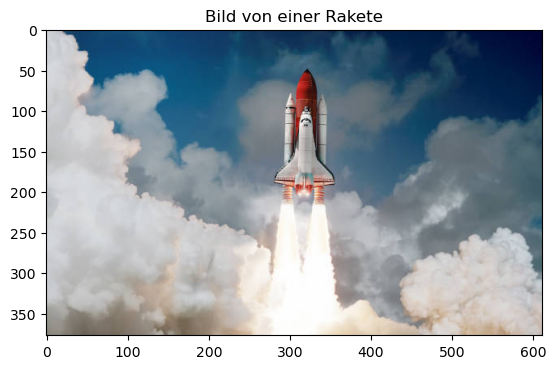

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


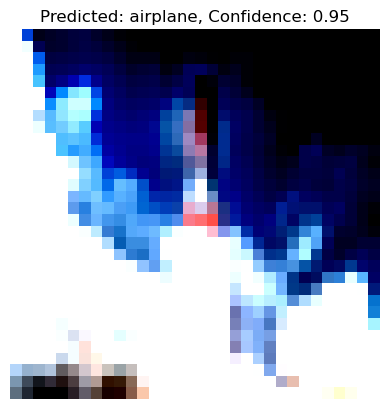

In [107]:
# Bild laden, welches weder Vogel noch Flugzeug
# enthält, von dem Netz aber mit mindestens 
# 95% wahrscheinlichkeit als eines der beiden Objekte 
# erkannt wird: 

# Laden des Bildes:
input_image = Image.open("Rakete.jpg")
plt.imshow(input_image)
plt.title('Bild von einer Rakete')
plt.show()

# Bild transformieren
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Größenanpassung auf die erwartete Eingabegröße des Modells
    transforms.ToTensor(),  # Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisierung der Farbkanäle
])

# Transformation des Bildes
my_image = transform(input_image)

outputs = model(my_image.unsqueeze(0))  # Bild ins Modell geben
probabilities = F.softmax(outputs, dim=1)
confidences, predicted_labels = torch.max(probabilities, dim=1)

if predicted_labels.item() == 0 or predicted_labels.item() == 1:  # Vogel oder Flugzeug?
    if confidences.item() > 0.94:  # Wahrscheinlichkeit >= 95%
        m_label = class_names[predicted_labels.item()]  # Klasse
        m_confidence = confidences.item()    # Wahrscheinlichkeit

        # Bild in das korrekte Format umwandeln
        image = my_image.squeeze().numpy()  
        image = image.transpose((1, 2, 0)) 

        # Darstellung des Bildes:
        plt.imshow(image)
        plt.title(f"Predicted: {m_label}, Confidence: {m_confidence:.2f}")
        plt.axis('off')
        plt.show()
    else:
        print('Keine Confidence höher als 0.95')
